# Boro Player Predictions - Current Market Value

Written report for this analysis can be found [here](../reports/boro_01_market_value.md)

In [1]:
## standard library
import os
import sys
import re
import pickle
import shutil

In [2]:
## data wrangling
import numpy as np
import pandas as pd

pd.set_option("display.latex.repr", True)
pd.set_option('precision', 3)

In [3]:
## visualisation
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

import seaborn as sns
sns.set()

In [4]:
## machine learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
# from sklearn.feature_selection import SelectKBest, f_regression
# from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import Lasso
# from sklearn.linear_model import Ridge
# from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.svm import SVR
# from sklearn.utils import resample
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance

In [5]:
## project src
sys.path.insert(0, os.path.abspath('..'))
sys.path.insert(0, os.path.abspath('../src'))
# sys.path

%load_ext autoreload
%autoreload 2

import src.utilities as utilities

In [6]:
## global constants
RANDOM_STATE = 4

## 1. Business Understanding

* Determine Busines Objectives
* Situation Assessment
* Determine Data Mining Goal
* Produce Project Plan

The aim of this project is to see if we can use data on players at Middlesbrough Football Club to make preditions about the player's and the team's current and future performance.

We have player data from Transfermarkt, ESPN, WhoScored and Fly Me To The Moon (fanzine).

"Performance" could be measured in many different ways: Results on the pitch, market value, fan popularity, churn, ...

A number of key performance metrics will be investigated in turn, looking at how predictable each is...

1) Current market value

2) Current fan popularity

3) Current performance rating

... and more TBC ...


## 2. Data Understanding

* Collect Initial Data
* Describe Data
* Explore Data
* Verify Data Quality

In [7]:
print("Loading Transfermarkt general information...")

tmk_df = utilities.get_master("players_contract")
# tmk_df.info()

Loading Transfermarkt general information...
tmk_cnt_mbr_all_0910.csv
tmk_cnt_mbr_all_1011.csv
tmk_cnt_mbr_all_1112.csv
tmk_cnt_mbr_all_1213.csv
tmk_cnt_mbr_all_1314.csv
tmk_cnt_mbr_all_1415.csv
tmk_cnt_mbr_all_1516.csv
tmk_cnt_mbr_all_1617.csv
tmk_cnt_mbr_all_1718.csv
tmk_cnt_mbr_all_1819.csv
tmk_cnt_mbr_all_1920.csv


In [8]:
print("Random sample of records...")

tmk_df.sample(8, random_state=RANDOM_STATE)

Random sample of records...


,Shirt number,Position,Name,Date of birth,Height,Foot,Joined,Contract expires,Market value,Season,Position group,Age
547,6.0,Centre-Back,Ben Gibson,1993-01-15,185.0,left,2011-07-01,2021-06-30,510.000,16/17,D,24
424,3.0,Left-Back,George Friend,1987-10-19,188.0,left,2012-07-30,2018-06-30,0.975,14/15,D,26
643,NaN,Central Midfield,Grant Leadbitter,1986-01-07,177.0,right,2012-07-01,2018-06-30,180.000,17/18,M,32
28,NaN,Left-Back,Andrew Taylor,1986-08-01,178.0,left,2005-07-01,NaT,188.000,09/10,D,22
711,NaN,Centre-Forward,Britt Assombalonga,1992-12-06,177.0,NaN,2017-07-17,2021-06-30,900.000,18/19,F,26
48,NaN,Defensive Midfield,Isaiah Osbourne,1987-11-05,188.0,right,2009-11-06,NaT,0.375,09/10,M,21
677,NaN,Left-Back,George Friend,1987-10-19,188.0,left,2012-07-30,2020-06-30,135.000,18/19,D,31
168,NaN,Centre Forward,Leroy Lita,1984-12-28,176.0,right,2009-07-01,NaT,150.000,10/11,F,25


In [9]:
print("Summary of whole data source...")

tmk_df.describe(include="all")

Summary of whole data source...


C:\Users\adeacon\AppData\Local\Continuum\miniconda3\envs\tbir2\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\adeacon\AppData\Local\Continuum\miniconda3\envs\tbir2\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\adeacon\AppData\Local\Continuum\miniconda3\envs\tbir2\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Treating 

,Shirt number,Position,Name,Date of birth,Height,Foot,Joined,Contract expires,Market value,Season,Position group,Age
count,119.000,362,362,362,354.000,322,349,167,328.000,362,362,362.000
unique,NaN,19,171,169,NaN,3,126,11,NaN,11,4,NaN
top,NaN,Centre Back,Ben Gibson,1993-01-15 00:00:00,NaN,right,2010-07-01 00:00:00,2019-06-30 00:00:00,NaN,09/10,M,NaN
freq,NaN,53,9,9,NaN,199,31,27,NaN,47,133,NaN
first,NaN,NaN,NaN,1973-08-27 00:00:00,NaN,NaN,2000-07-01 00:00:00,2016-05-31 00:00:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2000-10-11 00:00:00,NaN,NaN,2020-07-31 00:00:00,2023-06-30 00:00:00,NaN,NaN,NaN,NaN
mean,17.345,NaN,NaN,NaN,183.302,NaN,NaN,NaN,146.639,NaN,NaN,24.807
std,10.966,NaN,NaN,NaN,5.960,NaN,NaN,NaN,191.985,NaN,NaN,4.706
min,1.000,NaN,NaN,NaN,170.000,NaN,NaN,NaN,0.038,NaN,NaN,16.000
25%,8.000,NaN,NaN,NaN,179.000,NaN,NaN,NaN,0.375,NaN,NaN,21.000


**ANALYSIS:** So the data is looking broadly in good shape, but there are a few missing values to consider...

In [10]:
# print("% populated...")

pd.DataFrame(100 * tmk_df.count() / tmk_df.shape[0], columns=["% populated"])

,% populated
Shirt number,32.873
Position,100.000
Name,100.000
Date of birth,100.000
Height,97.790
Foot,88.950
Joined,96.409
Contract expires,46.133
Market value,90.608
Season,100.000


In [11]:
print("Players with missing Joined dates...")

tmk_df.loc[tmk_df.Name.isin(tmk_df[tmk_df.Joined.notna()].Name.values)
       & tmk_df.Name.isin(tmk_df[tmk_df.Joined.isna()].Name.values)].sort_values(by=["Name", "Season"])[["Name", "Season", "Joined"]].T

Players with missing Joined dates...


,156,220,300,374,454,26,120,194,266,348,416,490,547,616,24,122,282,364,440,512,60,154,218,298,102,182,250,334,406,482,542,92,174,242,322,396,476
Name,Adam Reach,Adam Reach,Adam Reach,Adam Reach,Adam Reach,Ben Gibson,Ben Gibson,Ben Gibson,Ben Gibson,Ben Gibson,Ben Gibson,Ben Gibson,Ben Gibson,Ben Gibson,Bruno Pilatos,Bruno Pilatos,Bryn Morris,Bryn Morris,Bryn Morris,Bryn Morris,Cameron Park,Cameron Park,Cameron Park,Cameron Park,Connor Ripley,Connor Ripley,Connor Ripley,Connor Ripley,Connor Ripley,Connor Ripley,Connor Ripley,Luke Williams,Luke Williams,Luke Williams,Luke Williams,Luke Williams,Luke Williams
Season,10/11,11/12,12/13,13/14,14/15,09/10,10/11,11/12,12/13,13/14,14/15,15/16,16/17,17/18,09/10,10/11,12/13,13/14,14/15,15/16,09/10,10/11,11/12,12/13,10/11,11/12,12/13,13/14,14/15,15/16,16/17,09/10,10/11,11/12,12/13,13/14,14/15
Joined,NaT,2011-07-01 00:00:00,2011-07-01 00:00:00,2011-07-01 00:00:00,2011-07-01 00:00:00,NaT,2010-07-01 00:00:00,2010-07-01 00:00:00,2010-07-01 00:00:00,2010-07-01 00:00:00,2010-07-01 00:00:00,2010-07-01 00:00:00,2011-07-01 00:00:00,2011-07-01 00:00:00,NaT,2010-07-01 00:00:00,NaT,2014-01-01 00:00:00,2014-01-01 00:00:00,2014-01-01 00:00:00,NaT,NaT,2011-07-01 00:00:00,2011-07-01 00:00:00,NaT,2011-07-01 00:00:00,2011-07-01 00:00:00,2011-07-01 00:00:00,2011-07-01 00:00:00,2011-07-01 00:00:00,2011-07-01 00:00:00,NaT,2010-07-01 00:00:00,2010-07-01 00:00:00,2010-07-01 00:00:00,2010-07-01 00:00:00,2010-07-01 00:00:00


In [12]:
print("Players with missing Contract expires dates...")

tmk_df.loc[tmk_df.Name.isin(tmk_df[tmk_df["Contract expires"].notna()].Name.values)
       & tmk_df.Name.isin(tmk_df[tmk_df["Contract expires"].isna()].Name.values)].sort_values(by=["Name", "Season"])[["Name", "Season", "Contract expires"]].T

Players with missing Contract expires dates...


,156,220,300,374,454,26,120,194,266,348,416,490,547,616,282,364,440,512,102,182,250,334,406,482,542,384,466,470,603,661,330,400,486,611,726
Name,Adam Reach,Adam Reach,Adam Reach,Adam Reach,Adam Reach,Ben Gibson,Ben Gibson,Ben Gibson,Ben Gibson,Ben Gibson,Ben Gibson,Ben Gibson,Ben Gibson,Ben Gibson,Bryn Morris,Bryn Morris,Bryn Morris,Bryn Morris,Connor Ripley,Connor Ripley,Connor Ripley,Connor Ripley,Connor Ripley,Connor Ripley,Connor Ripley,Lee Tomlin,Lee Tomlin,Patrick Bamford,Patrick Bamford,Patrick Bamford,Tomás Mejías,Tomás Mejías,Tomás Mejías,Tomás Mejías,Tomás Mejías
Season,10/11,11/12,12/13,13/14,14/15,09/10,10/11,11/12,12/13,13/14,14/15,15/16,16/17,17/18,12/13,13/14,14/15,15/16,10/11,11/12,12/13,13/14,14/15,15/16,16/17,13/14,14/15,14/15,16/17,17/18,13/14,14/15,15/16,17/18,19/20
Contract expires,NaT,2019-06-30 00:00:00,2019-06-30 00:00:00,2019-06-30 00:00:00,2019-06-30 00:00:00,NaT,2019-06-30 00:00:00,2019-06-30 00:00:00,2019-06-30 00:00:00,2019-06-30 00:00:00,2019-06-30 00:00:00,2019-06-30 00:00:00,2021-06-30 00:00:00,2022-06-30 00:00:00,NaT,2016-06-30 00:00:00,2016-06-30 00:00:00,2016-06-30 00:00:00,NaT,NaT,NaT,NaT,NaT,2018-06-30 00:00:00,2018-06-30 00:00:00,NaT,2017-06-30 00:00:00,NaT,2021-06-30 00:00:00,2021-06-30 00:00:00,NaT,2018-06-30 00:00:00,2018-06-30 00:00:00,2018-06-30 00:00:00,2021-06-30 00:00:00


**ANALYSIS:** _Possibly_ we could back fill some missing `Joined` and `Contract expires` dates but this might have some undesired consequences because the date _might_ not be valid for that particular season. We'll leave them as Nulls for now.

Text(0, 0.5, 'Number of players')

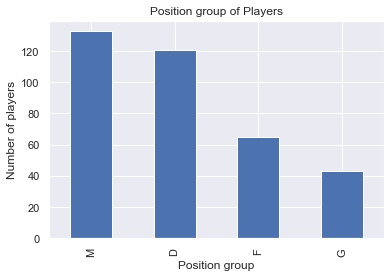

In [13]:
tmk_df["Position group"].value_counts().plot(kind='bar')
plt.title('Position group of Players')
plt.xlabel('Position group')
plt.ylabel('Number of players');

Text(0, 0.5, 'Number of players')

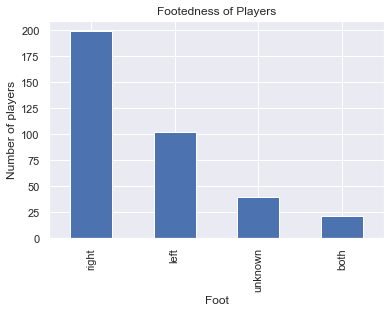

In [14]:
tmk_df.Foot.fillna("unknown").value_counts().plot(kind='bar')
plt.title('Footedness of Players')
plt.xlabel('Foot')
plt.ylabel('Number of players');

Text(0, 0.5, 'Number of players')

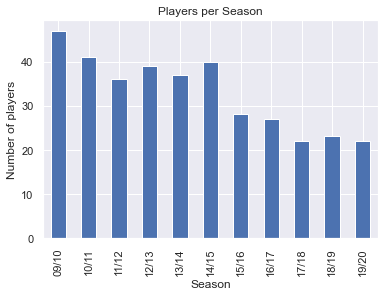

In [15]:
tmk_df.Season.value_counts().sort_index().plot(kind='bar')
plt.title('Players per Season')
plt.xlabel('Season')
plt.ylabel('Number of players');

Text(0, 0.5, 'Number of players')

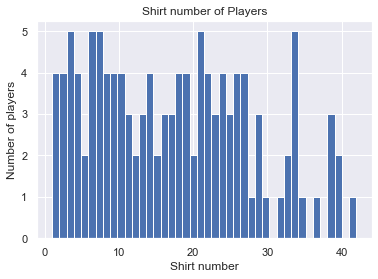

In [16]:
tmk_df["Shirt number"].hist(bins=42)
plt.title('Shirt number of Players')
plt.xlabel('Shirt number')
plt.ylabel('Number of players');

Text(0, 0.5, 'Number of players')

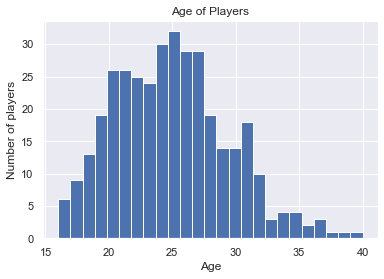

In [17]:
tmk_df["Age"].hist(bins=25)
plt.title('Age of Players')
plt.xlabel('Age')
plt.ylabel('Number of players');

Text(0, 0.5, 'Number of players')

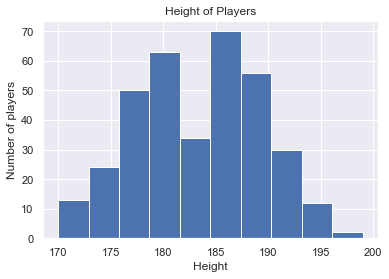

In [18]:
tmk_df["Height"].hist()
plt.title('Height of Players')
plt.xlabel('Height')
plt.ylabel('Number of players');

Text(0, 0.5, 'Number of players')

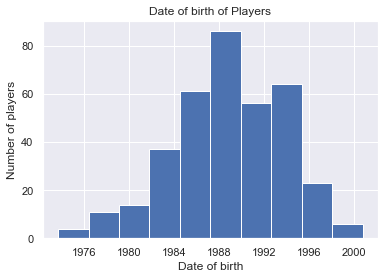

In [19]:
tmk_df["Date of birth"].hist()
plt.title('Date of birth of Players')
plt.xlabel('Date of birth')
plt.ylabel('Number of players');

Text(0, 0.5, 'Number of players')

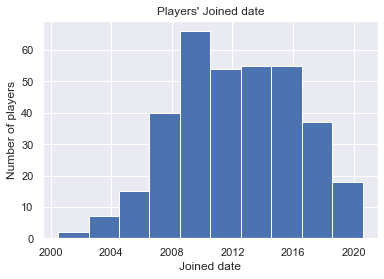

In [20]:
tmk_df["Joined"].hist()
plt.title("Players' Joined date")
plt.xlabel('Joined date')
plt.ylabel('Number of players');

Text(0, 0.5, 'Number of players')

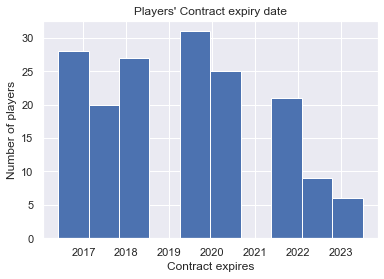

In [21]:
tmk_df["Contract expires"].hist()
plt.title("Players' Contract expiry date")
plt.xlabel('Contract expires')
plt.ylabel('Number of players');

Text(0, 0.5, 'Number of players')

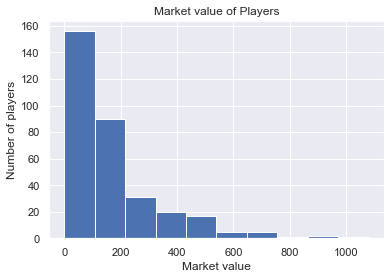

In [22]:
tmk_df["Market value"].hist()
plt.title("Market value of Players")
plt.xlabel('Market value')
plt.ylabel('Number of players');

Text(0.5, 1.08, 'Pair plots of Shirt number, Height, Market value and Age')

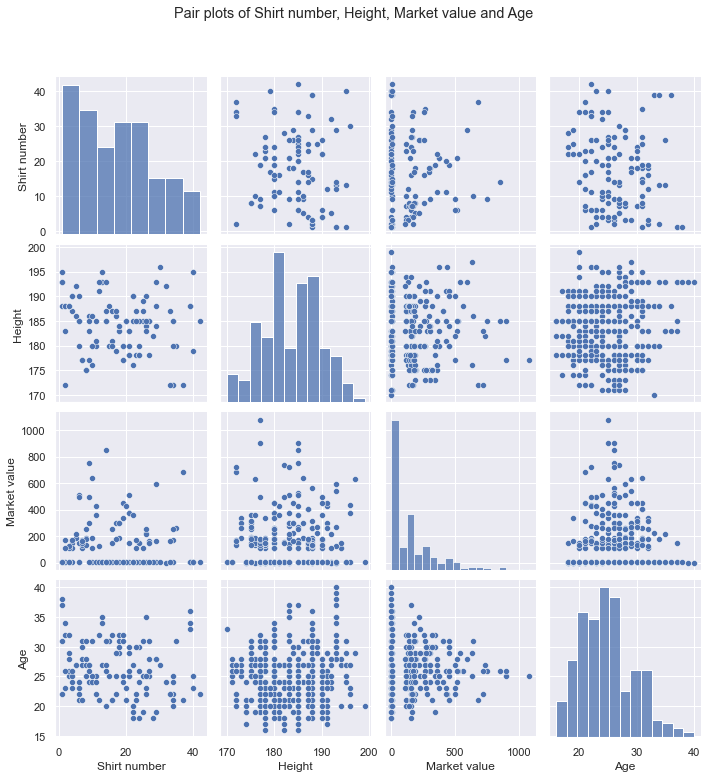

In [23]:
g = sns.pairplot(tmk_df)
g.fig.suptitle("Pair plots of Shirt number, Height, Market value and Age", y=1.08);

Text(0.5, 1.08, 'Pair plots of Shirt number, Height, Market value and Age grouped by Position group')

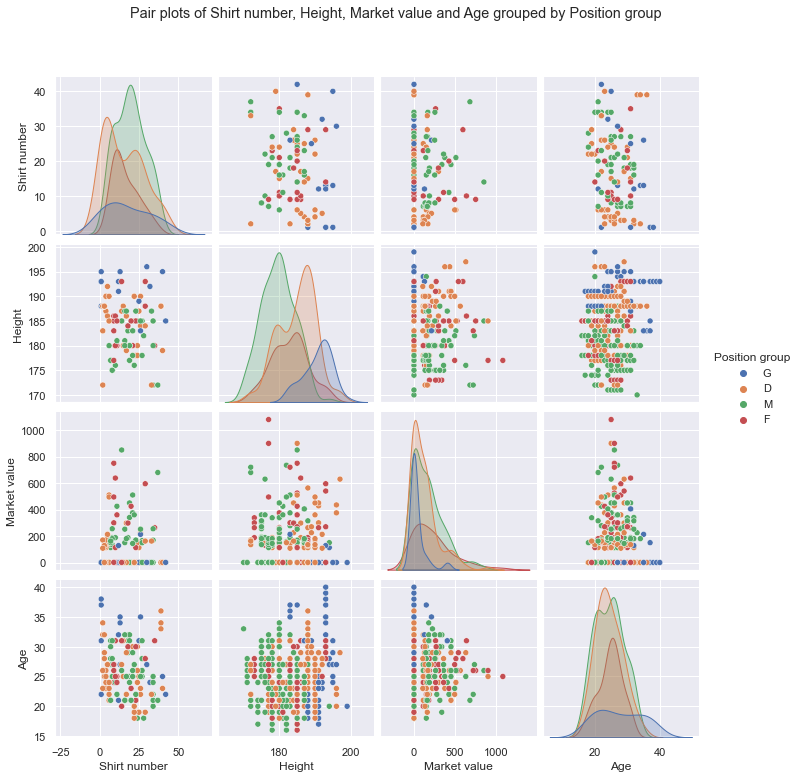

In [24]:
g = sns.pairplot(tmk_df, hue="Position group")
g.fig.suptitle("Pair plots of Shirt number, Height, Market value and Age grouped by Position group", y=1.08);

C:\Users\adeacon\AppData\Local\Continuum\miniconda3\envs\tbir2\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.08, 'Pair plots of Shirt number, Height, Market value and Age grouped by Foot')

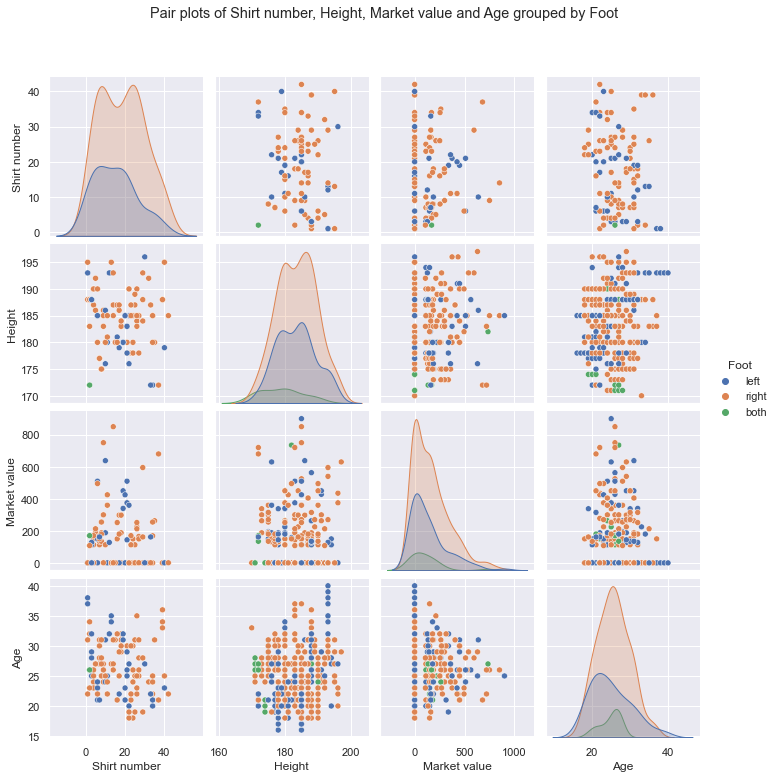

In [25]:
g = sns.pairplot(tmk_df, hue="Foot")
g.fig.suptitle("Pair plots of Shirt number, Height, Market value and Age grouped by Foot", y=1.08);

In [26]:
print("Loading Transfermarkt performance summary...")

# import players
# psm_df = utilities.folder_loader("tmk_psm", ["Shirt number", "Position", "Name", "Age", "Nationality",
#                                 "In squad", "Appearances", "Goals", "Assists", 
#                                     "Yellow cards", "Second yellow cards", "Red cards",
#                                    "Substitutions on", "Substitutions off", "PPG", "Minutes played"])

psm_df = utilities.get_master("players_performance")
# psm_df.info()

Loading Transfermarkt performance summary...
tmk_psm_mbr_chm_0910.csv
tmk_psm_mbr_chm_1011.csv
tmk_psm_mbr_chm_1112.csv
tmk_psm_mbr_chm_1213.csv
tmk_psm_mbr_chm_1314.csv
tmk_psm_mbr_chm_1415.csv
tmk_psm_mbr_chm_1516.csv
tmk_psm_mbr_chm_1718.csv
tmk_psm_mbr_chm_1819.csv
tmk_psm_mbr_chm_1920.csv
tmk_psm_mbr_cpo_1415.csv
tmk_psm_mbr_cpo_1718.csv
tmk_psm_mbr_fac_0910.csv
tmk_psm_mbr_fac_1011.csv
tmk_psm_mbr_fac_1112.csv
tmk_psm_mbr_fac_1213.csv
tmk_psm_mbr_fac_1314.csv
tmk_psm_mbr_fac_1415.csv
tmk_psm_mbr_fac_1516.csv
tmk_psm_mbr_fac_1617.csv
tmk_psm_mbr_fac_1718.csv
tmk_psm_mbr_fac_1819.csv
tmk_psm_mbr_fac_1920.csv
tmk_psm_mbr_lec_0910.csv
tmk_psm_mbr_lec_1011.csv
tmk_psm_mbr_lec_1112.csv
tmk_psm_mbr_lec_1213.csv
tmk_psm_mbr_lec_1314.csv
tmk_psm_mbr_lec_1415.csv
tmk_psm_mbr_lec_1516.csv
tmk_psm_mbr_lec_1617.csv
tmk_psm_mbr_lec_1718.csv
tmk_psm_mbr_lec_1819.csv
tmk_psm_mbr_lec_1920.csv
tmk_psm_mbr_prm_1617.csv


In [27]:
print("Random sample of records...")

psm_df.sample(8, random_state=RANDOM_STATE)

Random sample of records...


,Shirt number,Position,Name,Age,In squad,Games started,Goals,Assists,Yellow cards,Second yellow cards,Red cards,Substitutions on,Substitutions off,PPG,Minutes played,Season,Competition,Position group
965,NaN,Right-Back,Justin Hoyte,24.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,90.0,09/10,FA Cup,D
1922,NaN,Right Midfield,Barry Robson,31.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00,90.0,10/11,League Cup,M
331,NaN,Centre Forward,Lukas Jutkiewicz,23.0,29.0,24.0,8.0,4.0,1.0,0.0,0.0,6.0,10.0,1.08,1527.0,12/13,Championship,F
1806,NaN,Defensive Midfield,Didier Digard,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,09/10,League Cup,M
1499,NaN,Right-Back,Calum Chambers,22.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.00,180.0,16/17,FA Cup,D
2493,NaN,Centre-Back,Sam Stubbs,20.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,18/19,League Cup,D
1603,8.0,Central Midfield,Adam Clayton,29.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.50,115.0,17/18,FA Cup,M
2633,1.0,Keeper,Dimitrios Konstantopoulos,38.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.00,90.0,16/17,Premier League,G


In [28]:
print("Summary of whole data source...")

psm_df.describe(include="all")

Summary of whole data source...


,Shirt number,Position,Name,Age,In squad,Games started,Goals,Assists,Yellow cards,Second yellow cards,Red cards,Substitutions on,Substitutions off,PPG,Minutes played,Season,Competition,Position group
count,526.000,1263,1263,1263.000,1263.000,1263.000,1263.000,1263.000,1263.000,1263.000,1263.000,1263.000,1263.000,1263.000,1263.000,1263,1263,1263
unique,NaN,20,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,5,4
top,NaN,Centre Back,Ben Gibson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14/15,League Cup,M
freq,NaN,176,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160,403,465
mean,17.101,NaN,NaN,24.689,7.289,6.070,0.553,0.426,0.716,0.019,0.020,1.184,1.184,0.870,440.517,NaN,NaN,NaN
std,10.939,NaN,NaN,4.686,12.462,11.112,1.717,1.259,1.859,0.148,0.145,2.813,2.868,1.027,859.479,NaN,NaN,NaN
min,1.000,NaN,NaN,16.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN,NaN,NaN
25%,7.250,NaN,NaN,21.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN,NaN,NaN
50%,17.000,NaN,NaN,24.000,2.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,90.000,NaN,NaN,NaN
75%,25.000,NaN,NaN,28.000,5.000,4.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.560,270.000,NaN,NaN,NaN


**ANALYSIS:** So the data is looking broadly in good shape

Text(0, 0.5, 'Number of players')

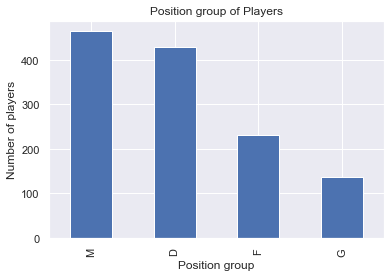

In [29]:
psm_df["Position group"].value_counts().plot(kind='bar')
plt.title('Position group of Players')
plt.xlabel('Position group')
plt.ylabel('Number of players');

Text(0, 0.5, 'Number of players')

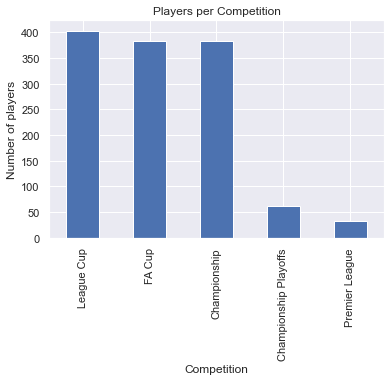

In [30]:
psm_df.Competition.value_counts().plot(kind='bar')
plt.title('Players per Competition')
plt.xlabel('Competition')
plt.ylabel('Number of players');

Text(0, 0.5, 'Number of players')

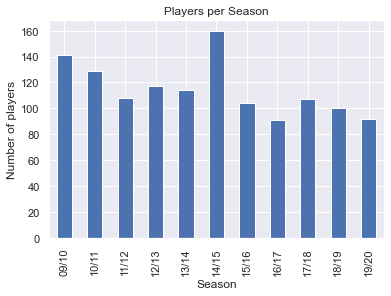

In [31]:
psm_df.Season.value_counts().sort_index().plot(kind='bar')
plt.title('Players per Season')
plt.xlabel('Season')
plt.ylabel('Number of players');

Text(0, 0.5, 'Number of players')

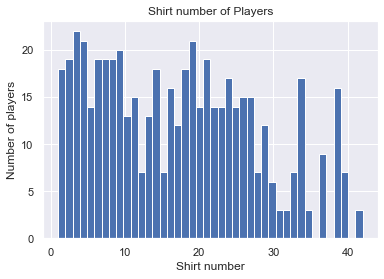

In [32]:
psm_df["Shirt number"].hist(bins=42)
plt.title('Shirt number of Players')
plt.xlabel('Shirt number')
plt.ylabel('Number of players');

Text(0, 0.5, 'Number of players')

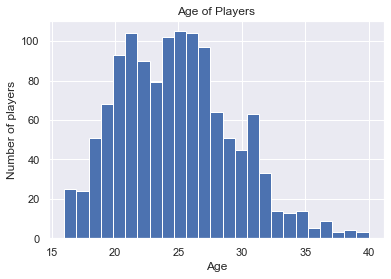

In [33]:
psm_df["Age"].hist(bins=25)
plt.title('Age of Players')
plt.xlabel('Age')
plt.ylabel('Number of players');

Text(0.5, 1.08, 'Pair plots of usage, goals, assists, yellow cards, PPG')

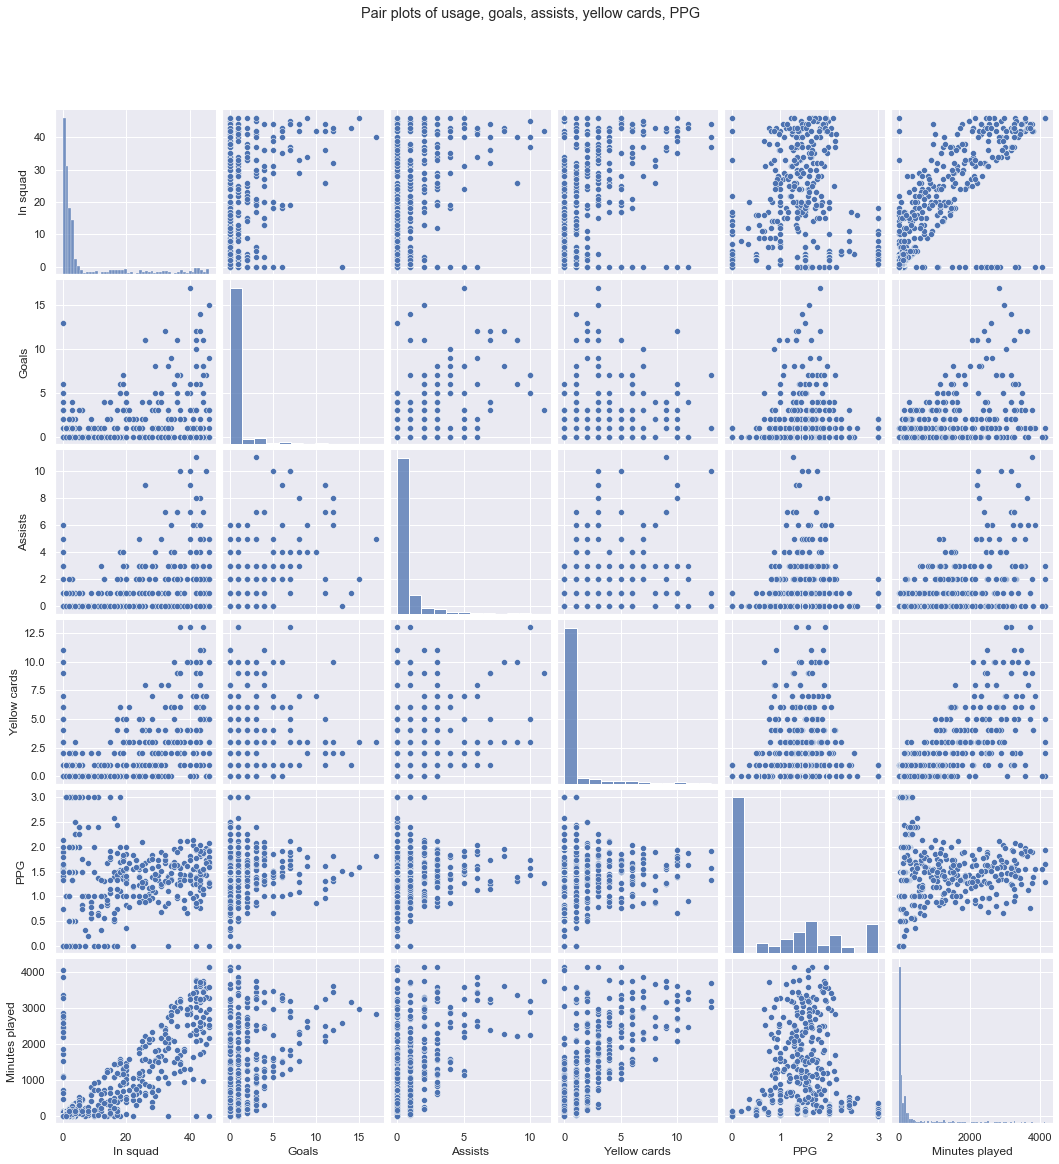

In [34]:
g = sns.pairplot(psm_df[["In squad", "Goals", "Assists", 
            "Yellow cards", #"Second yellow cards", "Red cards",
            "PPG", "Minutes played"]])
g.fig.suptitle("Pair plots of usage, goals, assists, yellow cards, PPG", y=1.08);

C:\Users\adeacon\AppData\Local\Continuum\miniconda3\envs\tbir2\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.08, 'Pair plots of usage, goals, assists, yellow cards, PPG by Position group')

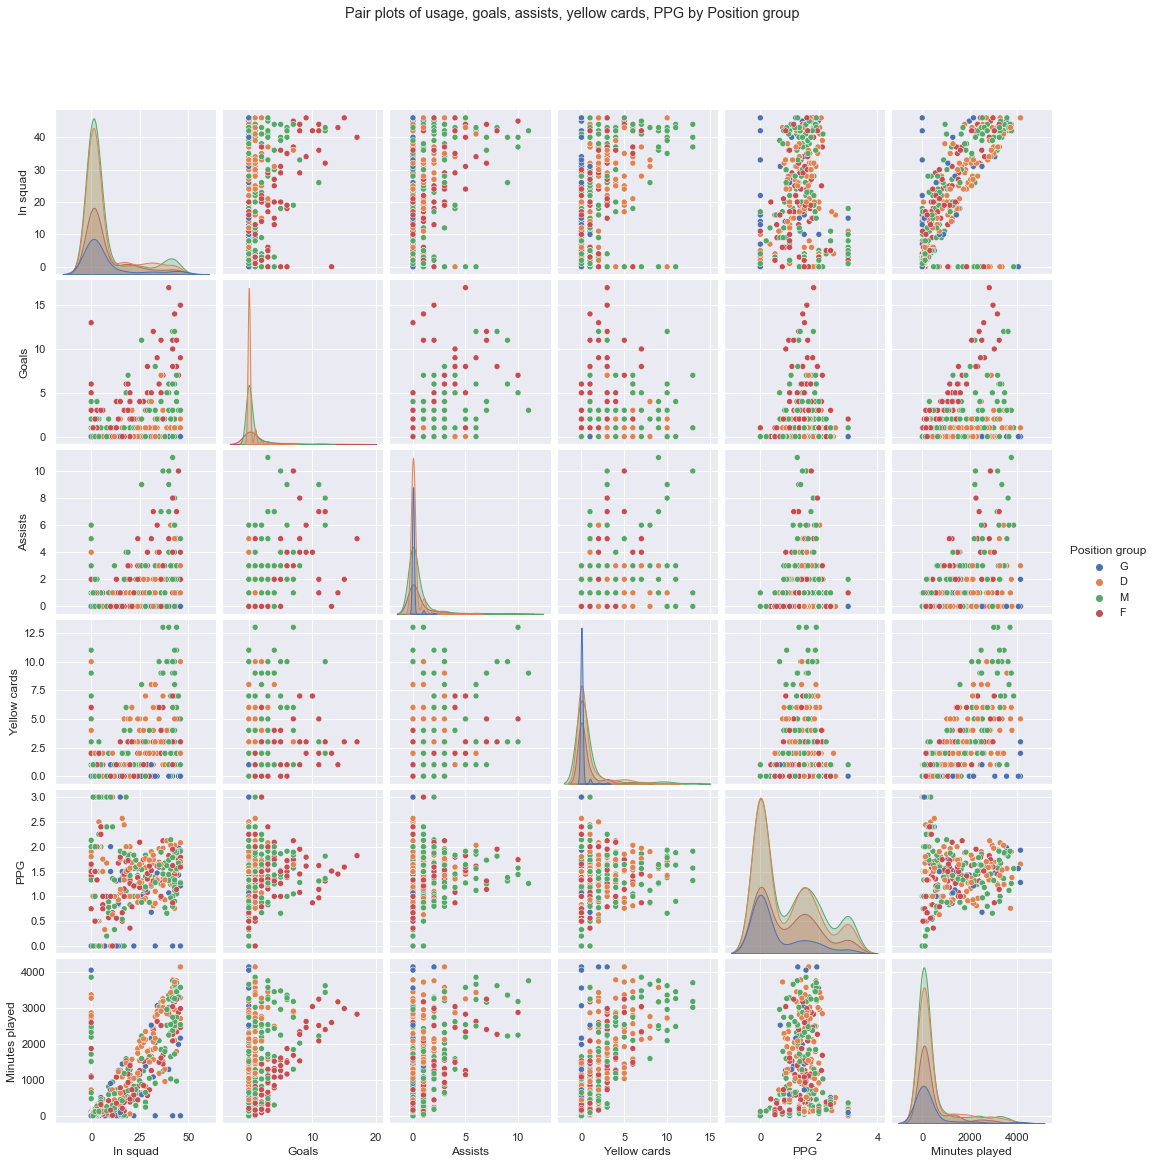

In [35]:
g = sns.pairplot(psm_df[["In squad", "Goals", "Assists", 
            "Yellow cards", #"Second yellow cards", "Red cards",
            "PPG", "Minutes played", "Position group"]], hue="Position group")
g.fig.suptitle("Pair plots of usage, goals, assists, yellow cards, PPG by Position group", y=1.08);

Text(0.5, 1.08, 'Pair plots of usage, goals, assists, yellow cards, PPG by Competition')

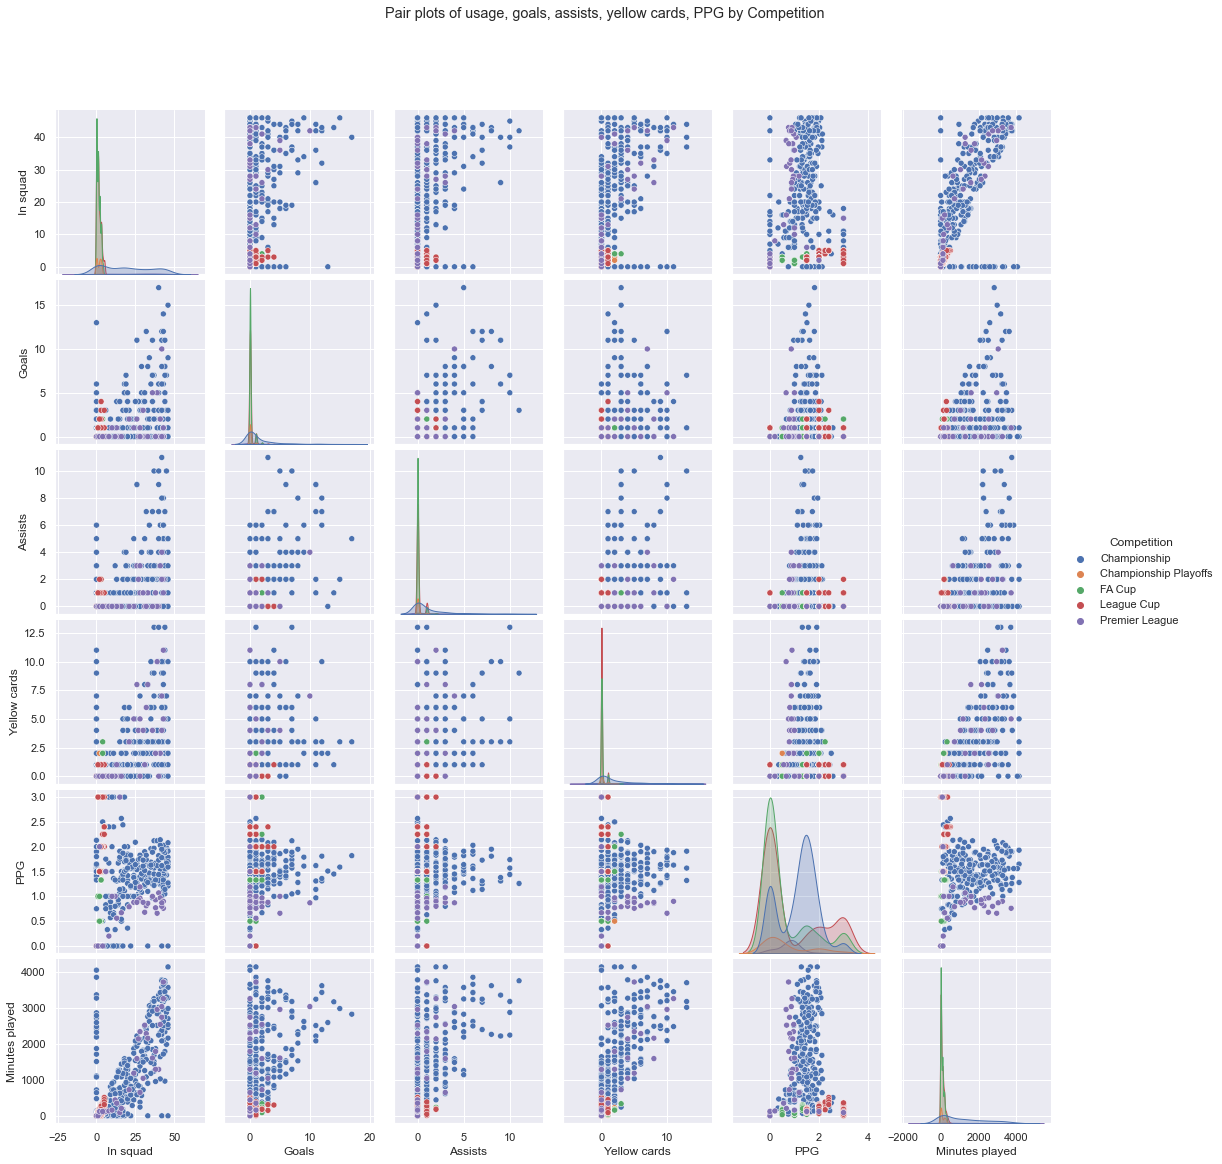

In [36]:
g = sns.pairplot(psm_df[["In squad", "Goals", "Assists", 
            "Yellow cards", #"Second yellow cards", "Red cards",
            "PPG", "Minutes played", "Competition"]], hue="Competition")
g.fig.suptitle("Pair plots of usage, goals, assists, yellow cards, PPG by Competition", y=1.08);

## 3. Data Preperation

* Select Data
* Clean Data
* Construct Data
* Integrate Data
* Format Data

In [37]:
df = tmk_df.copy()
# df.shape

df["Player key"] = df.Name + " (" + df.Season + ")"
df.set_index(df["Player key"], drop=True, inplace=True, verify_integrity=True)
df.drop(columns=["Player key"], inplace=True)

print("Final dataset created with index from {0} to {1}.".format(df.index[0], df.index[-1]))

Final dataset created with index from Brad Jones (09/10) to Rudy Gestede (19/20).


Text(0, 0.5, 'Number of players')

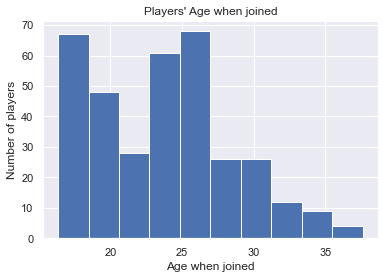

In [38]:
df["Age when joined"] = (df["Joined"] - df["Date of birth"])/ np.timedelta64(1, 'Y')
df["Age when joined"].hist()
plt.title("Players' Age when joined")
plt.xlabel('Age when joined')
plt.ylabel('Number of players');

**ANALYSIS:** Most players join in their teens or mid-twenties.

Text(0, 0.5, 'Number of players')

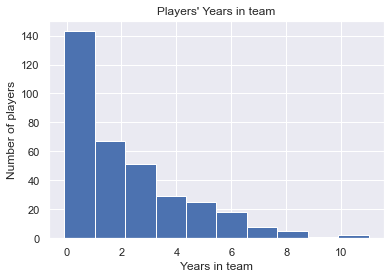

In [39]:
df["Years in team"] = (pd.to_datetime("1st July 20"+df.Season.str[-2:]) - df["Joined"])/ np.timedelta64(1, 'Y')
df["Years in team"].hist()
plt.title("Players' Years in team")
plt.xlabel('Years in team')
plt.ylabel('Number of players');

**ANALYSIS:** I'm going to leave out `Position`, `Date of birth`, `Joined`, and `Contract expires` from the model for now. `Contract expires` is populated in less than half of records. The others are encoded in derived features now.

In [40]:
df.drop(columns=["Position", "Name", "Date of birth", "Joined", "Season", "Contract expires"], inplace=True)
# df.shape

<s>**ANALYSIS:** `Foot` and `Position group` will be one-hot encoded</s>

In [41]:
# for var in ["Foot", "Position group"]:
#     df = pd.concat(
#         [
#             df.drop(var, axis=1),
#             pd.get_dummies(
#                 df[var], prefix=var, prefix_sep="=", drop_first=False
#             ),
#         ],
#         axis=1,
#     )

# df.describe()
# df.shape

In [42]:
psm_df.columns

Index(['Shirt number', 'Position', 'Name', 'Age', 'In squad', 'Games started',
       'Goals', 'Assists', 'Yellow cards', 'Second yellow cards', 'Red cards',
       'Substitutions on', 'Substitutions off', 'PPG', 'Minutes played',
       'Season', 'Competition', 'Position group'],
      dtype='object')

In [43]:
def psm_agg(x):
    d = {}
    
    d["Shirt number"] = x["Shirt number"].max()
    d["Age"] = x["Age"].max()
    d["Position group"] = x["Position group"].max()
    
    d["Competition"] = x["Competition"].agg(lambda a: ', '.join(a.sort_values()))
    
    d["In squad"] = x["In squad"].sum()
    d["Games started"] = x["Games started"].sum()
    d["Goals"] = x["Goals"].sum()
    d["Assists"] = x["Assists"].sum()
    d["Yellow cards"] = x["Yellow cards"].sum()
    d["Second yellow cards"] = x["Second yellow cards"].sum()
    d["Red cards"] = x["Red cards"].sum()
    d["Substitutions on"] = x["Substitutions on"].sum()
    d["Substitutions off"] = x["Substitutions off"].sum()
    d["Minutes played"] = x["Minutes played"].sum()
    
    x["Appearances"] = x["Games started"] + x["Substitutions on"]
    d["Appearances"] = x["Appearances"].sum()
    
    d["PPG"] = ((x["PPG"] * x["Appearances"]).sum() / x["Appearances"].sum())
    
    d["Goals p90"] = x["Goals"].sum() * 90 / x["Minutes played"].sum()
    d["Assists p90"] = x["Assists"].sum() * 90 / x["Minutes played"].sum()
    d["Yellow cards p90"] = x["Yellow cards"].sum() * 90 / x["Minutes played"].sum()
    
    return pd.Series(d, index=["Shirt number", "Age", "Position group", "Competition",
                                "In squad", "Appearances", "Games started", 
                               "Goals", "Assists", 
                                    "Yellow cards", "Second yellow cards", "Red cards",
                                   "Substitutions on", "Substitutions off", "PPG", "Minutes played",
                              "Goals p90", "Assists p90", "Yellow cards p90"])

psm_agg?

In [44]:
df2 = psm_df.groupby(["Name", "Season"]).apply(psm_agg).fillna(0)
df2.reset_index(inplace=True)
df2["Player key"] = df2.Name + " (" + df2.Season + ")"
df2.set_index(df2["Player key"], drop=True, inplace=True, verify_integrity=True)
df2.drop(columns=["Player key", "Name", "Season"], inplace=True)

# df = pd.concat([df, df2], axis=1)
df = df.combine_first(df2)

C:\Users\adeacon\AppData\Local\Continuum\miniconda3\envs\tbir2\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\adeacon\AppData\Local\Continuum\miniconda3\envs\tbir2\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\adeacon\AppData\Local\Continuum\miniconda3\envs\tbir2\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\adeacon\AppData\Local\Continuum\miniconda3\envs\tbir2\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


In [45]:
print("Random sample of records...")

df.sample(5, random_state=RANDOM_STATE)

Random sample of records...


,Age,Age when joined,Appearances,Assists,Assists p90,Competition,Foot,Games started,Goals,Goals p90,Height,In squad,Market value,Minutes played,PPG,Position group,Red cards,Second yellow cards,Shirt number,Substitutions off,Substitutions on,Years in team,Yellow cards,Yellow cards p90
Player key,,,,,,,,,,,,,,,,,,,,,,,,
Barry Robson (11/12),32.0,31.152,39.0,10.0,0.272,"Championship, FA Cup, League Cup",left,39.0,9.0,0.244,180.0,39.0,113.00,3314.0,1.592,M,1.0,0.0,0.0,11.0,0.0,2.497,13.0,0.353
Adam Jackson (13/14),19.0,NaN,0.0,0.0,0.000,Championship,NaN,0.0,0.0,0.000,NaN,2.0,NaN,0.0,0.000,D,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.000
Stewart Downing (17/18),33.0,30.982,53.0,7.0,0.174,"Championship, Championship Playoffs, FA Cup, L...",left,47.0,3.0,0.075,180.0,47.0,225.00,3616.0,1.701,M,0.0,0.0,19.0,19.0,6.0,2.960,1.0,0.025
Marvin Johnson (17/18),27.0,26.749,30.0,2.0,0.243,"Championship, Championship Playoffs, FA Cup, L...",left,18.0,1.0,0.121,178.0,25.0,180.00,741.0,1.684,M,0.0,0.0,21.0,2.0,12.0,0.832,0.0,0.000
Sean St. Ledger (09/10),24.0,24.715,16.0,0.0,0.000,"Championship, FA Cup, League Cup",right,15.0,2.0,0.142,182.0,15.0,0.75,1268.0,1.070,D,0.0,0.0,0.0,0.0,1.0,0.791,0.0,0.000


In [46]:
print("Summary of whole dataset...")

df.describe(include="all")

Summary of whole dataset...


,Age,Age when joined,Appearances,Assists,Assists p90,Competition,Foot,Games started,Goals,Goals p90,Height,In squad,Market value,Minutes played,PPG,Position group,Red cards,Second yellow cards,Shirt number,Substitutions off,Substitutions on,Years in team,Yellow cards,Yellow cards p90
count,444.000,349.000,444.000,444.000,444.000,444,322,444.000,444.000,444.000,354.000,444.000,328.000,444.000,444.000,444,444.000,444.000,444.000,444.000,444.000,349.000,444.000,444.000
unique,NaN,NaN,NaN,NaN,NaN,12,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,"Championship, FA Cup, League Cup",right,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,274,199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,24.574,23.852,20.637,1.212,0.070,NaN,NaN,17.268,1.572,0.095,183.302,20.734,146.639,1253.092,1.264,NaN,0.056,0.054,6.678,3.369,3.369,2.437,2.036,0.105
std,4.630,4.751,18.423,2.083,0.138,NaN,NaN,15.873,2.998,0.185,5.960,17.093,191.985,1270.250,0.836,NaN,0.250,0.246,10.716,4.587,4.470,1.998,2.978,0.162
min,16.000,16.356,0.000,0.000,0.000,NaN,NaN,0.000,0.000,0.000,170.000,0.000,0.038,0.000,0.000,NaN,0.000,0.000,0.000,0.000,0.000,-0.082,0.000,0.000
25%,21.000,19.409,2.000,0.000,0.000,NaN,NaN,2.000,0.000,0.000,179.000,4.000,0.375,96.500,0.779,NaN,0.000,0.000,0.000,0.000,0.000,0.914,0.000,0.000
50%,24.000,23.907,17.000,0.000,0.000,NaN,NaN,14.000,0.000,0.000,183.000,18.000,113.000,837.000,1.355,NaN,0.000,0.000,0.000,2.000,1.000,1.955,1.000,0.037
75%,27.000,26.495,38.000,2.000,0.105,NaN,NaN,30.000,2.000,0.111,188.000,36.000,216.000,2154.500,1.700,NaN,0.000,0.000,11.000,5.000,5.000,3.411,3.000,0.172


Text(0, 0.5, 'Number of players')

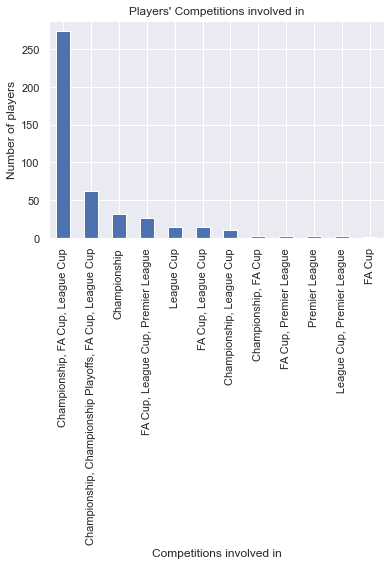

In [47]:
df.Competition.value_counts().plot(kind="bar")
plt.title("Players' Competitions involved in")
plt.xlabel('Competitions involved in')
plt.ylabel('Number of players');

In [48]:
# g = sns.pairplot(df[["Shirt number", "Height", "Age", "Age when joined", "Years in team", "Market value"]])
# g.fig.suptitle("Pair plots of Shirt number, Height, Age, Age when joined, Years in team and Market value", y=1.08);

df.corr().style.background_gradient(cmap='coolwarm')

# sns.heatmap(df.corr(), 
#             xticklabels=df.columns.values,
#             yticklabels=df.columns.values)

,Age,Age when joined,Appearances,Assists,Assists p90,Games started,Goals,Goals p90,Height,In squad,Market value,Minutes played,PPG,Red cards,Second yellow cards,Shirt number,Substitutions off,Substitutions on,Years in team,Yellow cards,Yellow cards p90
Age,1.000,0.903,0.255,0.123,-0.030,0.286,0.100,0.058,0.115,0.234,0.132,0.304,0.158,0.117,0.010,0.183,0.150,0.036,0.060,0.239,0.190
Age when joined,0.903,1.000,0.127,0.079,-0.066,0.144,0.089,0.052,0.074,0.096,0.143,0.150,0.081,0.049,-0.037,0.178,0.112,0.010,-0.363,0.142,0.149
Appearances,0.255,0.127,1.000,0.612,0.212,0.977,0.578,0.241,-0.186,0.814,0.372,0.894,0.279,0.227,0.178,0.263,0.693,0.652,0.032,0.660,0.278
Assists,0.123,0.079,0.612,1.000,0.510,0.613,0.594,0.273,-0.249,0.505,0.206,0.574,0.169,0.238,0.079,0.136,0.587,0.344,-0.009,0.473,0.173
Assists p90,-0.030,-0.066,0.212,0.510,1.000,0.177,0.265,0.279,-0.196,0.145,0.079,0.121,0.270,0.088,0.010,0.051,0.273,0.247,-0.018,0.102,0.037
Games started,0.286,0.144,0.977,0.613,0.177,1.000,0.537,0.179,-0.137,0.822,0.378,0.968,0.267,0.225,0.200,0.229,0.637,0.475,0.083,0.708,0.278
Goals,0.100,0.089,0.578,0.594,0.265,0.537,1.000,0.594,-0.164,0.406,0.322,0.456,0.140,0.093,0.035,0.098,0.646,0.473,-0.105,0.332,0.131
Goals p90,0.058,0.052,0.241,0.273,0.279,0.179,0.594,1.000,-0.156,0.109,0.262,0.096,0.241,0.016,-0.005,0.002,0.326,0.357,-0.150,0.062,0.038
Height,0.115,0.074,-0.186,-0.249,-0.196,-0.137,-0.164,-0.156,1.000,-0.099,-0.065,-0.063,-0.010,0.001,-0.013,0.055,-0.304,-0.271,0.047,-0.181,-0.074
In squad,0.234,0.096,0.814,0.505,0.145,0.822,0.406,0.109,-0.099,1.000,0.125,0.785,0.277,0.204,0.173,0.173,0.504,0.438,0.085,0.567,0.267


**ANALYSIS**: I'll remove `Games started` and `Age when joined` as they are closely correlated with other features.

In [49]:
df.columns

Index(['Age', 'Age when joined', 'Appearances', 'Assists', 'Assists p90',
       'Competition', 'Foot', 'Games started', 'Goals', 'Goals p90', 'Height',
       'In squad', 'Market value', 'Minutes played', 'PPG', 'Position group',
       'Red cards', 'Second yellow cards', 'Shirt number', 'Substitutions off',
       'Substitutions on', 'Years in team', 'Yellow cards',
       'Yellow cards p90'],
      dtype='object')

In [50]:
df.shape

(444, 24)

## 4. Modelling

* Select Modelling Technique
* Generate Test Design
* Build Model
* Assess Model

In [51]:
numeric_features = ['Shirt number', 
                'Height', 'Age', #'Age when joined', 
                    'Years in team', 
                    'In squad', 'Appearances', #'Games started', 
                    'Substitutions on', 'Substitutions off', 
                    'Goals', 'Assists', 
                    'Yellow cards', 'Second yellow cards', 'Red cards', 
                    'PPG', 'Minutes played',
                   'Goals p90', 'Assists p90', 'Yellow cards p90']

print("\n")
print("Selected numeric features are: {0}".format(numeric_features))



Selected numeric features are: ['Shirt number', 'Height', 'Age', 'Years in team', 'In squad', 'Appearances', 'Substitutions on', 'Substitutions off', 'Goals', 'Assists', 'Yellow cards', 'Second yellow cards', 'Red cards', 'PPG', 'Minutes played', 'Goals p90', 'Assists p90', 'Yellow cards p90']


In [52]:
categorical_features = ['Foot', 'Position group', 'Competition']

print("\n")
print("Selected categorical features are: {0}".format(categorical_features))



Selected categorical features are: ['Foot', 'Position group', 'Competition']


In [53]:
feature_names = numeric_features + categorical_features

# print("\n")
# print("Selected features are: {0}".format(feature_names))

In [54]:
drop_nulls = False

print("\n")
print("Dropping nulls during data preparation: {0}".format(drop_nulls))



Dropping nulls during data preparation: False


In [55]:
if drop_nulls:
    X = df[df.notna().all(axis=1)][feature_names]
    y = df[df.notna().all(axis=1)]["Market value"]
else:
    X = df[df["Market value"].notna()][feature_names]
    y = df[df["Market value"].notna()]["Market value"]
    
# X.shape, y.shape

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, train_size=0.9)

# X_train.shape, X_test.shape, y_train.shape, y_test.shape
print("\n")
print("Train data has shape: {0}".format(X_train.shape))
print("Test data has shape: {0}".format(X_test.shape))



Train data has shape: (295, 21)
Test data has shape: (33, 21)


In [57]:
number_of_folds = 10
# number_of_folds

In [58]:
kfold = KFold(n_splits=number_of_folds, shuffle=True, random_state=RANDOM_STATE)
# kfold

In [59]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

model = Pipeline(steps=[('preprocessor', preprocessor),
#                         ('basis', PolynomialFeatures()),
#                         ('reduction', SelectKBest(f_regression)),
                      ('estimator', GradientBoostingRegressor())])

In [60]:
param_grid = {
#             "reduction__k": [5, 10, 15],
#             "estimator__n_estimators": [10, 20, 30],
#              "estimator__max_depth": [1, 3, 5],
#              "estimator__min_samples_split": [0.1, 0.2, 0.3],
#               "estimator__max_features": ["auto", "sqrt", "log2"],
              "estimator__random_state": [RANDOM_STATE],
#             "estimator__kernel": ['linear'] #, 'poly', 'rbf', 'sigmoid', 'precomputed']
#             "estimator__gamma": ["scale", "auto"]
             }
# param_grid

In [61]:
grid = GridSearchCV(model, param_grid, cv=kfold)
# grid

In [62]:
print("\n")
print("Full model grid-space to tune hyperparameters across...")
grid.fit(X_train, y_train)



Full model grid-space to tune hyperparameters across...


GridSearchCV(cv=KFold(n_splits=10, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Shirt '
                                                                          'number',
                                                                          'Height',
                                                                          'Age',
                               

In [63]:
# grid.best_params_

In [64]:
final_model = grid.best_estimator_
# final_model

In [65]:
print("\n")
print("Final tuned model...")
final_model.fit(X_train, y_train)



Final tuned model...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Shirt number', 'Height',
                                                   'Age', 'Years in team',
                                                   'In squad', 'Appearances',
                                                   'Substitutions on',
                                                   'Substitutions off', 'Goals',
                                                   'Assists', 'Yellow cards',
                                                   'Second yellow cards',
                                 

## 5. Evaluation

* Evaluate Results
* Review Process
* Determine Next Steps

In [66]:
def model_scores(y_act, y_pred):
    """
    INPUT:
        y_act - Actual values from target vector
        y_pred - Predicted values from target vector
        
    OUTPUT:
        Dictionary containing multiple scoring metrics with nice labels as keys
    """
    
    return {"MedAE": median_absolute_error(y_act, y_pred),
            "RMSE": mean_squared_error(y_act, y_pred, squared=False),
            "R^2": r2_score(y_act, y_pred),
           }

# model_scores?

In [67]:
print("Model scores")

pd.DataFrame(
    [model_scores(y_train, final_model.predict(X_train)), 
    model_scores(y_test, final_model.predict(X_test))], 
    index=["Train", "Test"]
    ).T

Model scores


,Train,Test
MedAE,30.674,72.180
RMSE,59.879,231.422
R^2,0.900,-0.207


**ANALYSIS:** Switching from random forest to gradient boost has improved the training scores further... but the test scores are (arguably) slightly worse.

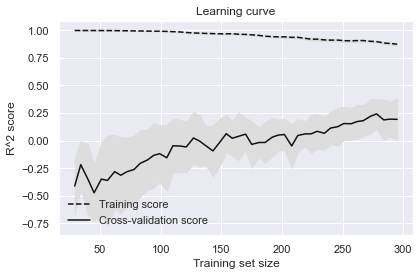

In [68]:
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(final_model, 
                                                        X, 
                                                        y,
                                                        cv=kfold,
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.1, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning curve")
plt.xlabel("Training set size"), plt.ylabel("R^2 score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

**ANALYSIS:** Scores are converging slowly now so more data could well help.

C:\Users\adeacon\AppData\Local\Continuum\miniconda3\envs\tbir2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\adeacon\AppData\Local\Continuum\miniconda3\envs\tbir2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Market value (predicted)')

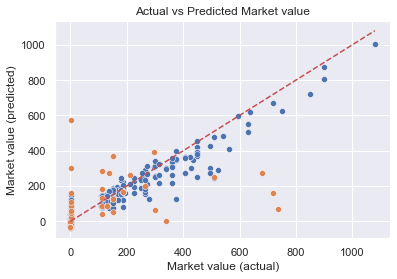

In [69]:
sns.scatterplot(y_train, final_model.predict(X_train))
sns.scatterplot(y_test, final_model.predict(X_test))

mv_range = [y.min(), y.max()]
plt.plot(mv_range, mv_range, '--r')
plt.title('Actual vs Predicted Market value')
plt.xlabel('Market value (actual)')
plt.ylabel('Market value (predicted)');

**ANALYSIS:** Our predictions are still undershooting in general but the training data is getting very close (overfitting?)

In [70]:
# transformed_features = list(numeric_features) \
#     + final_model['preprocessor'].transformers_[1][1]['onehot']\
#                          .get_feature_names(categorical_features).tolist()
# transformed_features

In [71]:
def show_significant_features(features, labels):
    r = permutation_importance(final_model, features, labels,
                            n_repeats=30,
                            random_state=RANDOM_STATE)

    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print("{0} {1:.3f} +/- {2:.3f}".format(feature_names[i].ljust(20), 
#                                                 transformed_features[i].ljust(20), 
                                                    r.importances_mean[i],
                                                    r.importances_std[i]))

show_significant_features?

In [72]:
print("\nSignificant training features:")
show_significant_features(X_train, y_train)

print("\nSignificant testing features:")
show_significant_features(X_test, y_test)


Significant training features:
Minutes played       0.267 +/- 0.023
Age                  0.132 +/- 0.015
Shirt number         0.124 +/- 0.021
Years in team        0.115 +/- 0.012
In squad             0.114 +/- 0.013
Goals                0.076 +/- 0.011
Position group       0.066 +/- 0.009
Appearances          0.062 +/- 0.008
PPG                  0.050 +/- 0.005
Substitutions off    0.048 +/- 0.008
Height               0.046 +/- 0.005
Competition          0.042 +/- 0.006
Yellow cards p90     0.028 +/- 0.003
Assists p90          0.025 +/- 0.004
Foot                 0.020 +/- 0.002
Yellow cards         0.020 +/- 0.003
Goals p90            0.019 +/- 0.004
Substitutions on     0.010 +/- 0.002
Red cards            0.004 +/- 0.001
Assists              0.004 +/- 0.001
Second yellow cards  0.002 +/- 0.001

Significant testing features:
Substitutions on     0.022 +/- 0.011


**ANALYSIS:** `Minutes played`, `Goals`, `Appearances`, `Age`, `Position group` and `In squad` are particularly influencing the model. Of those, only `In squad` - along with `Yellow cards` and `Assists` - are generalising to new predictions.

## 6. Deployment

* Plan Deployment
* Plan Monitoring and Maintenance
* Produce Final Report
* Review Project

In [73]:
df_out = df.copy()
# df_out.shape

In [74]:
if drop_nulls:
    df_out["Market value (prediction)"] = np.NaN
    df_out.loc[df_out.notna()[feature_names].all(axis=1), "Market value (prediction)"] = final_model.predict(df_out[df_out.notna()[feature_names].all(axis=1)][feature_names])
else:
    df_out["Market value (prediction)"] = final_model.predict(df_out[feature_names])

# df_out.shape

In [75]:
print("Summary of whole dataset (with predictions)...")

df_out.describe(include="all")

Summary of whole dataset (with predictions)...


,Age,Age when joined,Appearances,Assists,Assists p90,Competition,Foot,Games started,Goals,Goals p90,Height,In squad,Market value,Minutes played,PPG,Position group,Red cards,Second yellow cards,Shirt number,Substitutions off,Substitutions on,Years in team,Yellow cards,Yellow cards p90,Market value (prediction)
count,444.000,349.000,444.000,444.000,444.000,444,322,444.000,444.000,444.000,354.000,444.000,328.000,444.000,444.000,444,444.000,444.000,444.000,444.000,444.000,349.000,444.000,444.000,444.000
unique,NaN,NaN,NaN,NaN,NaN,12,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,"Championship, FA Cup, League Cup",right,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,274,199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,24.574,23.852,20.637,1.212,0.070,NaN,NaN,17.268,1.572,0.095,183.302,20.734,146.639,1253.092,1.264,NaN,0.056,0.054,6.678,3.369,3.369,2.437,2.036,0.105,121.183
std,4.630,4.751,18.423,2.083,0.138,NaN,NaN,15.873,2.998,0.185,5.960,17.093,191.985,1270.250,0.836,NaN,0.250,0.246,10.716,4.587,4.470,1.998,2.978,0.162,144.072
min,16.000,16.356,0.000,0.000,0.000,NaN,NaN,0.000,0.000,0.000,170.000,0.000,0.038,0.000,0.000,NaN,0.000,0.000,0.000,0.000,0.000,-0.082,0.000,0.000,-41.834
25%,21.000,19.409,2.000,0.000,0.000,NaN,NaN,2.000,0.000,0.000,179.000,4.000,0.375,96.500,0.779,NaN,0.000,0.000,0.000,0.000,0.000,0.914,0.000,0.000,21.555
50%,24.000,23.907,17.000,0.000,0.000,NaN,NaN,14.000,0.000,0.000,183.000,18.000,113.000,837.000,1.355,NaN,0.000,0.000,0.000,2.000,1.000,1.955,1.000,0.037,80.313
75%,27.000,26.495,38.000,2.000,0.105,NaN,NaN,30.000,2.000,0.111,188.000,36.000,216.000,2154.500,1.700,NaN,0.000,0.000,11.000,5.000,5.000,3.411,3.000,0.172,169.356


In [76]:
df_unseen = df_out[df_out["Market value"].isna()]
# df_unseen.shape

In [77]:
print("Summary of unseen records in dataset (no labels)...")

df_unseen[df_unseen["Market value (prediction)"].notna()].describe(include="all")

Summary of unseen records in dataset (no labels)...


,Age,Age when joined,Appearances,Assists,Assists p90,Competition,Foot,Games started,Goals,Goals p90,Height,In squad,Market value,Minutes played,PPG,Position group,Red cards,Second yellow cards,Shirt number,Substitutions off,Substitutions on,Years in team,Yellow cards,Yellow cards p90,Market value (prediction)
count,116.000,21.000,116.000,116.000,116.000,116,22,116.000,116.000,116.000,28.000,116.000,0.0,116.000,116.000,116,116.0,116.0,116.000,116.000,116.000,21.000,116.000,116.000,116.000
unique,NaN,NaN,NaN,NaN,NaN,11,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,"Championship, FA Cup, League Cup",left,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,43,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,21.922,18.725,6.974,0.345,0.051,NaN,NaN,5.509,0.543,0.076,182.179,8.224,NaN,369.828,1.033,NaN,0.0,0.0,1.922,1.259,1.466,1.486,0.560,0.044,56.342
std,4.386,1.370,9.302,1.064,0.178,NaN,NaN,7.620,1.488,0.208,5.683,8.971,NaN,568.992,1.103,NaN,0.0,0.0,6.442,2.575,2.483,0.997,1.347,0.095,77.773
min,16.000,17.054,0.000,0.000,0.000,NaN,NaN,0.000,0.000,0.000,172.000,0.000,NaN,0.000,0.000,NaN,0.0,0.0,0.000,0.000,0.000,0.334,0.000,0.000,-41.834
25%,19.000,17.687,0.000,0.000,0.000,NaN,NaN,0.000,0.000,0.000,178.000,1.000,NaN,0.000,0.000,NaN,0.0,0.0,0.000,0.000,0.000,0.991,0.000,0.000,-4.422
50%,21.000,18.404,3.000,0.000,0.000,NaN,NaN,2.000,0.000,0.000,182.500,4.000,NaN,90.000,0.823,NaN,0.0,0.0,0.000,0.000,0.000,0.999,0.000,0.000,26.569
75%,25.250,19.056,9.250,0.000,0.000,NaN,NaN,8.000,0.000,0.000,185.000,13.250,NaN,447.750,1.851,NaN,0.0,0.0,0.000,1.000,2.000,2.001,0.000,0.000,92.591


**ANALYSIS:** The player's missing actual Market values are mostly young players who haven't been used much.

In [78]:
print("Predictions below zero")

df_unseen[df_unseen["Market value (prediction)"] < 0.0].describe(include="all")
# pd.DataFrame(df_unseen.loc['Connor Ripley (11/12)'])

Predictions below zero


,Age,Age when joined,Appearances,Assists,Assists p90,Competition,Foot,Games started,Goals,Goals p90,Height,In squad,Market value,Minutes played,PPG,Position group,Red cards,Second yellow cards,Shirt number,Substitutions off,Substitutions on,Years in team,Yellow cards,Yellow cards p90,Market value (prediction)
count,34.000,7.000,34.000,34.000,34.000,34,6,34.000,34.0,34.0,12.000,34.000,0.0,34.000,34.000,34,34.0,34.0,34.0,34.000,34.000,7.000,34.000,34.000,34.000
unique,NaN,NaN,NaN,NaN,NaN,7,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,"Championship, FA Cup, League Cup",left,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,16,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,18.824,18.137,1.294,0.029,0.041,NaN,NaN,0.794,0.0,0.0,181.917,3.382,NaN,38.941,0.922,NaN,0.0,0.0,0.0,0.088,0.500,1.500,0.059,0.015,-13.471
std,2.844,0.603,1.624,0.171,0.241,NaN,NaN,1.067,0.0,0.0,5.760,4.314,NaN,72.866,1.309,NaN,0.0,0.0,0.0,0.288,0.707,1.041,0.343,0.086,11.265
min,16.000,17.457,0.000,0.000,0.000,NaN,NaN,0.000,0.0,0.0,174.000,0.000,NaN,0.000,0.000,NaN,0.0,0.0,0.0,0.000,0.000,0.496,0.000,0.000,-41.834
25%,17.000,17.572,0.000,0.000,0.000,NaN,NaN,0.000,0.0,0.0,178.000,1.000,NaN,0.000,0.000,NaN,0.0,0.0,0.0,0.000,0.000,1.001,0.000,0.000,-23.129
50%,18.500,18.377,0.000,0.000,0.000,NaN,NaN,0.000,0.0,0.0,182.000,2.000,NaN,0.000,0.000,NaN,0.0,0.0,0.0,0.000,0.000,1.002,0.000,0.000,-7.276
75%,19.750,18.499,2.750,0.000,0.000,NaN,NaN,1.750,0.0,0.0,185.000,4.000,NaN,48.500,2.375,NaN,0.0,0.0,0.0,0.000,1.000,2.001,0.000,0.000,-6.203


**ANALYSIS:** The model seems to particularly struggle with young players who we don't have much information about.

In [79]:
df_out.to_csv("../data/interim/boro_01_dataset.csv")

In [80]:
clf_file = "../models/boro_01_model.pkl" 
with open(clf_file, "wb") as clf_outfile:
    pickle.dump(final_model, clf_outfile)

In [81]:
ftn_file = "../models/boro_01_feature_names.pkl" 
with open(ftn_file, "wb") as ftn_outfile:
    pickle.dump(feature_names, ftn_outfile)

In [82]:
## save notebook before running `nbconvert`

In [83]:
# outFolder = './output'
# for filename in os.listdir(outFolder):
#     file_path = os.path.join(outFolder, filename)
#     try:
#         if os.path.isfile(file_path) or os.path.islink(file_path):
#             os.unlink(file_path)
#         elif os.path.isdir(file_path):
#             shutil.rmtree(file_path)
#     except Exception as e:
#         print('Failed to delete %s. Reason: %s' % (file_path, e))

In [84]:
# !jupyter nbconvert --no-input --output-dir='./output' --to markdown boro_01_current_market_value.ipynb

In [85]:
# !jupyter nbconvert --output-dir='./output' --to python boro_01_current_market_value.ipynb